# Author Information

**Author:** CHUA JINGXUAN

**Taylor's Student ID:** 0365376

**Email:** 0365376@sd.taylors.edu.my

**Note:** This Jupyter Notebook was written by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 28/07/2024 (SUN)

**Last Updated**: 30/07/2024 (TUE)

---
# ITS70804 Text and Image Processing: ASSIGNMENT 3
---

# Trial 02: EfficientNetB0 (Teacher) + DeiT-Tiny (Student)

# Importing Essential Libraries

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
import timm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# 1.0 Data Loading and Apply Augmentation

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalization for CIFAR-10
    ])

# Loading CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=get_transforms())
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=get_transforms())
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:18<00:00, 9207809.63it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 2.0 Instantiate Teacher and Student Model

In [ ]:
# Initialize the teacher model (EfficientNet-B0)
teacher_model = timm.create_model('efficientnet_b0', pretrained=True)
teacher_model.classifier = nn.Linear(teacher_model.classifier.in_features, 10)  # Adjust for CIFAR-10
teacher_model = teacher_model.eval()  # Set to evaluation mode

# Initialize the student model (DeiT Tiny)
student_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
student_model.train()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"Number of parameters in teacher model (EfficientNet-B0): {teacher_params}")
print(f"Number of parameters in student model (DeiT-Tiny): {student_params}")

Number of parameters in teacher model (EfficientNet-B0): 4020358
Number of parameters in student model (DeiT-Tiny): 5526346


# 3.0 Define Loss Function and Optimizer

In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0005)  # Smaller learning rate for fine-tuning

def distillation_loss(student_output, teacher_output, labels, T=3.0):
    soft_loss = F.kl_div(F.log_softmax(student_output/T, dim=1), F.softmax(teacher_output/T, dim=1), reduction='batchmean')
    hard_loss = F.cross_entropy(student_output, labels)
    return soft_loss + hard_loss

temperature = 3.0  # Temperature for softening probabilities

# 4.0 Model Training Loop and Timing

In [ ]:
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    start_time = time.time() # Start Timing

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(images)
        student_outputs = student_model(images)

        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_duration = time.time() - start_time
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds')

Epoch 1/50, Loss: 1.8536, Accuracy: 39.24%, Duration: 162.91 seconds
Epoch 2/50, Loss: 1.5833, Accuracy: 49.70%, Duration: 163.14 seconds
Epoch 3/50, Loss: 1.4733, Accuracy: 53.18%, Duration: 163.03 seconds
Epoch 4/50, Loss: 1.4122, Accuracy: 53.06%, Duration: 163.30 seconds
Epoch 5/50, Loss: 1.3578, Accuracy: 57.00%, Duration: 163.42 seconds
Epoch 6/50, Loss: 1.3057, Accuracy: 56.46%, Duration: 163.90 seconds
Epoch 7/50, Loss: 1.2580, Accuracy: 59.45%, Duration: 163.91 seconds
Epoch 8/50, Loss: 1.2141, Accuracy: 60.81%, Duration: 164.34 seconds
Epoch 9/50, Loss: 1.1726, Accuracy: 62.06%, Duration: 163.42 seconds
Epoch 10/50, Loss: 1.1391, Accuracy: 63.85%, Duration: 164.50 seconds
Epoch 11/50, Loss: 1.1033, Accuracy: 64.24%, Duration: 163.08 seconds
Epoch 12/50, Loss: 1.0703, Accuracy: 65.15%, Duration: 163.71 seconds
Epoch 13/50, Loss: 1.0382, Accuracy: 65.35%, Duration: 163.07 seconds
Epoch 14/50, Loss: 0.9995, Accuracy: 65.89%, Duration: 164.31 seconds
Epoch 15/50, Loss: 0.9704, Ac

In [ ]:
torch.save(student_model.state_dict(), './efficientnetb0_deit_student.pth')

# 5.0 Evaluate the Model

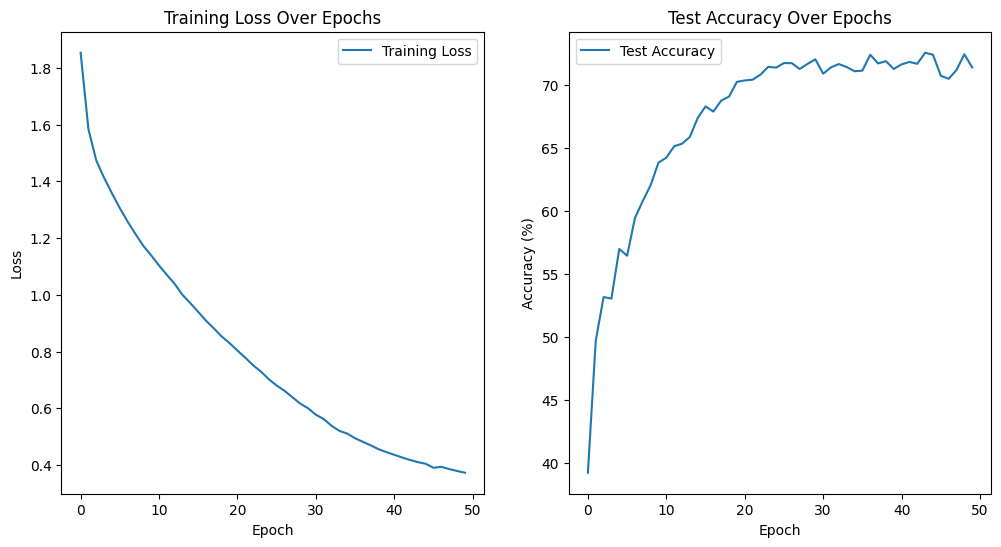

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# Generate classification report
all_preds = []
all_targets = []
student_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', classification_report(all_targets, all_preds))

Accuracy: 71.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73      1000
           1       0.76      0.86      0.81      1000
           2       0.67      0.61      0.64      1000
           3       0.53      0.59      0.56      1000
           4       0.71      0.66      0.68      1000
           5       0.58      0.65      0.61      1000
           6       0.79      0.77      0.78      1000
           7       0.77      0.71      0.74      1000
           8       0.81      0.82      0.81      1000
           9       0.85      0.73      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

